# Using Featuretools to analyze medals won at the Olympic Games
<p style="margin:30px">
    <img width=40% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</p>

In this notebook, we examine a dataset containing all the medals won by each athlete at each Summer Olympic Games. Our goal will be to see what quantities are important in predicting the future number of medals per country. To build a highly accurate machine learning model, it's necessary to extract certain transformations called **features**. Finding the right features is a crucial component of both finding a satisfactory answer and understanding what to do next. The process of **feature engineering** is made simple by [Featuretools](https://featuretools.com).

There's an [associated notebook](BaselineSolution.ipynb) which talks about making baselines for this problem by computing the average number of medals a country wins over time. The mean AUC in that notebook is .79, compared to .95 for the model we build here. While that notebook and this one give a brief introduction to Featuretools, all of the calls are explained in depth in the [documentation](docs.featuretools.com).



In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

import featuretools as ft

import utils as utils

%matplotlib inline

/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Step 1: Load data

Featuretools stores data in an `EntitySet`. This is an abstraction which us to hold on not only to the data itself, but also to metadata like relationships and column types. In general, creating an entityset can be as easy as calling `entityset_from_csv` inside of Featuretools. We'd like to be a little bit more subtle here, so we'll use a custom `load_entityset` function in [utils.py](utils.py).

In [2]:
DATA_DIR = os.path.join(os.getcwd(),"data/olympic_games_data")
es = utils.load_entityset(data_dir=DATA_DIR)

# Load a pre-made labels table for supervised learning
label_file = os.path.join(DATA_DIR, "num_medals_by_country_labels.csv")
label_df = pd.read_csv(label_file,
                       parse_dates=['Olympics Date'],
                       encoding='utf-8',
                       usecols=['Number of Medals', 'Olympics Date', 'Country'])
label_df.sort_values(['Olympics Date', 'Country'], inplace=True)

/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Visualize EntitySet

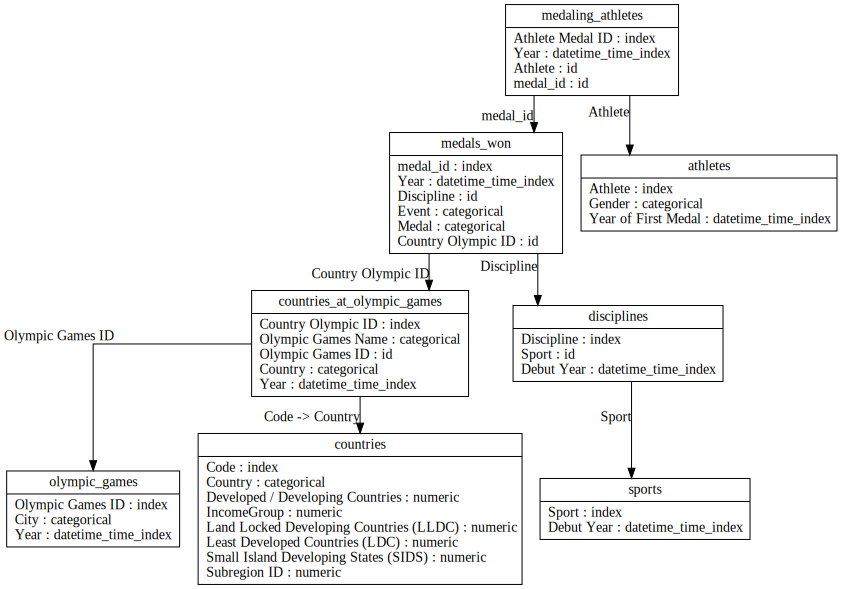

In [3]:
es.plot()

In [3]:
# Make a new label for binary classification
dates = label_df['Olympics Date']
labels = label_df['Number of Medals']
y_binary = (labels >= 10).values

## Cutoff times

We are going to be generating features and doing predictive modeling on Olympic Games throughout history. We want to see how accurate our model is at each Olympics, but that comes with potential for danger. Since we already know the answer, there's a risk that our **labels** will **leak** into the prediction and make it seem like our model is better than it really is.

To circumvent that, we introduce the notion of [cutoff times](https://docs.featuretools.com/automated_feature_engineering/handling_time.html) which tells the software which data it is allowed to use to make a certain prediction. For this dataset, we want to prevent any results from the current Olympics from being used. A `cutoff_time` has an index column and a datetime column indicating the last acceptable date Featuretools can use for a given prediction. Setting cutoff times immediately mitigates the risk of fradulently using results data, changes the number of predictions we make and impacts how Deep Feature Synthesis generates features.

In [4]:
cutoff_times = label_df[['Country', 'Olympics Date']].rename(columns={'Country': 'Code'})
cutoff_times.tail()

,Code,Olympics Date
1060,TUN,2012-06-29
1038,TUR,2012-06-29
1035,UKR,2012-06-29
1021,USA,2012-06-29
1027,UZB,2012-06-29


# Step 2: Generate Features Using Deep Feature Synthesis

We can specify particular primitives as building blocks to automatically construct features. Featuretools will walk through our EntitySet and apply each primitive as many times as possible using the [Deep Feature Synthesis](https://docs.featuretools.com/automated_feature_engineering/afe.html) (DFS) algorithm. 

The `max_depth` parameter tells DFS how deep to make each feature which is closely associated to how long the algorithm takes. With `max_depth=3` we create 290 features in about 5 minutes. If you are running this notebook yourself, try changing the max depth or the `agg_primitives` to see how that changes the rest of the results.

In [5]:
agg_primitives = ['Sum', 'Std', 'Max', 'Min', 'Mean', 
                  'Count', 'Percent_True', 'Num_Unique', 
                  'Mode', 'Trend', 'Skew']

feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity="countries",
    trans_primitives=[],
    agg_primitives=agg_primitives,
    max_depth=3,
    cutoff_time=cutoff_times,
    verbose=True
)

print("{} features generated".format(len(features)))

Built 295 features
Elapsed: 05:20 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
295 features generated


In [6]:
features[-10:]

[<Feature: SKEW(countries_at_olympic_games.TREND(medals_won.NUM_UNIQUE(medaling_athletes.Athlete), Year))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.COUNT(countries_at_olympic_games))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(countries_at_olympic_games.Olympic Games Name))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(countries_at_olympic_games.Country))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.COUNT(medals_won))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(medals_won.Discipline))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(medals_won.Event))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(medals_won.Medal))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.COUNT(medaling_athletes))>,
 <Feature: SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(medaling_athletes.Athlete))>]

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


You can see that we have done more than individually apply functions to particular columns. These features were not only computed at individual cutoff times for each Olympic Games, but they were also stacked and combined across the `countries_at_olympic_games`, `medals_won` and `medaling_athletes` tables from our EntitySet in an exhaustive way. Using the [Deep Feature Synthesis](https://docs.featuretools.com/automated_feature_engineering/afe.html) algorithm is powerful because it greatly increases the likelihood of finding important features while decreasing the workload of the data scientist.

## Data Manipulation 

Machine learning algorithms require all numeric values as input, but Featuretools by default produces some categorical values. One way to transform these values into numbers is to create several binary features that [encode](https://docs.featuretools.com/generated/featuretools.synthesis.encode_features.html) whether the feature is equal to each particular category. The number of categories is capped at 10 by default. 
 
We also use stock algorithms from scikit-learn, such as an imputer that replaces missing values with the mean over that feature and a scaler that makes sure each feature's values vary from 0 to 1. The `RobustScaler` class is more sensitive to outliers than the `StandardScaler`.

In [7]:
feature_matrix_encoded, features_encoded = ft.encode_features(feature_matrix, features)

pipeline_preprocessing = [("imputer",
                           Imputer(missing_values='NaN', strategy="mean", axis=0)),
                          ("scaler", RobustScaler(with_centering=True))]
feature_matrix_encoded.tail()

/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,Country = United Kingdom,Country = United States,Country = France,Country = Denmark,Country = Sweden,Country = Italy,Country = Hungary,Country = Canada,Country = Switzerland,Country = Netherlands,...,"SKEW(countries_at_olympic_games.TREND(medals_won.NUM_UNIQUE(medaling_athletes.Athlete), Year))",SKEW(countries_at_olympic_games.olympic_games.COUNT(countries_at_olympic_games)),SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(countries_at_olympic_games.Olympic Games Name)),SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(countries_at_olympic_games.Country)),SKEW(countries_at_olympic_games.olympic_games.COUNT(medals_won)),SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(medals_won.Discipline)),SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(medals_won.Event)),SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(medals_won.Medal)),SKEW(countries_at_olympic_games.olympic_games.COUNT(medaling_athletes)),SKEW(countries_at_olympic_games.olympic_games.NUM_UNIQUE(medaling_athletes.Athlete))
Code,,,,,,,,,,,,,,,,,,,,,
TUN,0,0,0,0,0,0,0,0,0,0,...,NaN,1.812802,0.0,1.812802,1.687661,1.734617,1.717044,0.0,1.854509,1.868663
TUR,0,0,0,0,0,0,0,0,0,0,...,0.0,0.852489,0.0,0.852489,0.301827,0.601136,0.351444,0.0,0.364836,0.403917
UKR,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,-1.962858,-1.539601,-1.918290,0.0,-1.704587,-1.776255
USA,0,1,0,0,0,0,0,0,0,0,...,0.0,0.495083,0.0,0.495083,0.170417,0.393931,0.185184,0.0,0.426942,0.445541
UZB,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,-1.962858,-1.539601,-1.918290,0.0,-1.704587,-1.776255


# Step 3: Build machine learning models and generate scores

## Time-based cross-validation

We cross-validate by separating training sets for each Olympics since 1960, using all historical data in the past for each. That step is taken done by `TimeSeriesSplitByDate`. After splitting, we can immediately make predictions using the feature matrix and the labels from above.

In [8]:
splitter = utils.TimeSeriesSplitByDate(dates=dates, earliest_date=pd.Timestamp('1/1/1960'))
X = feature_matrix_encoded.values

rf_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])
binary_scores = utils.fit_and_score(X, y_binary, splitter, pipeline, _type='classification')
"Average AUC score is {} with standard dev {}".format(
        round(binary_scores['roc_auc'].mean(), 3),
        round(np.std(binary_scores['roc_auc']), 3)
)

/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/utils.py:478: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  date_index = pd.concat([early_date_index, date_index])
/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; 

'Average AUC score is 0.939 with standard dev 0.033'

## Analysis

By incorporating automated feature engineering to our pipeline, our average score is now .95 as compared to the [baseline](BaselineSolution.ipynb) average score of .79. Our standard deviation is now also half the size as it was previously, with 0.021 as compared to 0.045. This means that our results have become more consistent across years. Let's begin by plotting our AUC score over time. 

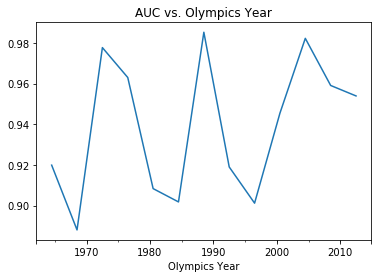

In [9]:
binary_scores.set_index('Olympics Year')['roc_auc'].plot(title='AUC vs. Olympics Year')

For particular years and countries our score is substantially worse. Let's look in detail at scores from 1984 and 2004 to see how many countries we predicted correctly in each binary category. A nice visual representation of that information is a *confusion matrix*.

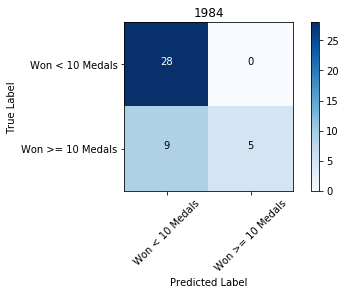

In [10]:
# 1984 = 5th split
split, year = 5, '1984'
train, test = splitter.split(X, y_binary)[split]
pipeline.fit(X[train], y_binary[train])
y_pred = pipeline.predict(X[test])
cm = confusion_matrix(y_binary[test], y_pred)
utils.plot_confusion_matrix(cm, ['Won < 10 Medals', 'Won >= 10 Medals'], title=year)


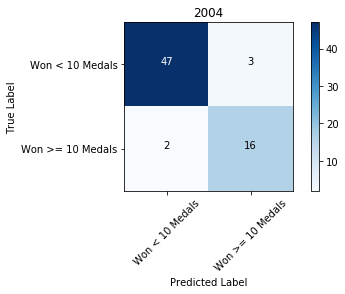

In [11]:
# 2004 = 10th split
split, year = 10, '2004'
train, test = splitter.split(X, y_binary)[split]
pipeline.fit(X[train], y_binary[train])
y_pred = pipeline.predict(X[test])
cm = confusion_matrix(y_binary[test], y_pred)
utils.plot_confusion_matrix(cm, ['Won < 10 Medals', 'Won >= 10 Medals'], title=year)

In 1984, we underestimated how many medals 8 countries scored, while in 2004, we underestimated only 2 countres and overestimated 1. This is likely due to the boycott in 1984 by Soviet Bloc countries, leading to more medals scored their competitors. 

Problems like this can arise from events occuring that are not represented in your data. For the Olympics, we can track specific rule changes, geopolitical events and widespread use of performance-enhancing drugs for inaccuracies in particular years. A summary can be found on [Wikipedia](https://en.wikipedia.org/wiki/List_of_Olympic_Games_scandals_and_controversies). In particular, we can see 
1. **Rule changes** - Between 1970 and 1992 the IOC gradually started allowing professional athletes and changing the medaling events
2. **Geopolitics** - Both the United States and Russia boycotted various years during the cold war. 
3. **Performance-enhancing drugs** see [this](https://en.wikipedia.org/wiki/Doping_at_the_Olympic_Games) article

## Feature Importances
Lastly, we can look at how useful generating deep features was for the score of the model. We'll use the built in `feature_importances_` method from a Random Forest classifier.

In [12]:
# Get feature importances for every year
feature_imp = utils.get_feature_importances(pipeline, 
                                            feature_matrix_encoded, 
                                            (labels >= 10), splitter)

/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/lecrintech/projects/python/demos-featuretools/demo7/v0.6.0/predict-olympic-medals/env3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and wil

In [13]:
# Show 10 most important features for 1984
test_date = pd.Timestamp('6/29/1984')
display(feature_imp[test_date].iloc[:5].reset_index(drop=True))

,Importance,Feature
0,0.024426,TREND(countries_at_olympic_games.NUM_UNIQUE(me...
1,0.023497,MEAN(countries_at_olympic_games.COUNT(medals_w...
2,0.022430,MEAN(countries_at_olympic_games.COUNT(medals_w...
3,0.019899,TREND(countries_at_olympic_games.NUM_UNIQUE(me...
4,0.019014,MEAN(countries_at_olympic_games.NUM_UNIQUE(med...


In the top five most important we see some features we expected and some that we didn't. In fact, the feature we constructed for our baseline, the average number of medals won by country, is the second most important feature in this model. Our most important feature, the average `SKEW` of the medaling distribution, would have been difficult to find by hand.

In [14]:
# Save output files

import os

try:
    os.mkdir("output")
except:
    pass

feature_matrix_encoded.to_csv('output/feature_matrix_encoded.csv', encoding='utf-8')
cutoff_times.to_csv('output/cutoff_times.csv', encoding='utf-8')

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).